In [1]:
import numpy as np
import pandas as pd
import time
import copy
import os
# import torch
# import torch.optim as optim
# import torch.nn as nn
# import torchvision
import matplotlib.pyplot as plt
# from torch.optim import lr_scheduler
# from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from PIL import Image

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
# import tensorflow as tf


# 2

In [3]:
# Download the pretrained VGG16 model
model_vgg16 = models.vgg16(pretrained=True)


/Users/namrata/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/namrata/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def extract_features(image_path):
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image_tensor = preprocess(image)
    image_tensor = torch.unsqueeze(image_tensor, 0)
    
    model_vgg16.eval()
    with torch.no_grad():
        features = model_vgg16.features(image_tensor)
#     print("Features Shape Before Flattening ",features.shape)
    features = features.flatten().numpy()
#     print("Features")
    #print("Features Shape ",features.shape)
    return features




# 3

In [5]:
def compute_mean_features(images, class_indices):
    features = []
    for i in class_indices:
        img_path = images[i]
        img_features = extract_features(img_path)#, model_vgg16)
        features.append(img_features)
    mean_features = np.mean(features, axis=0)
    print("Mu.shape", mean_features.shape)
    return mean_features

def compute_direction_of_means(images, class1_indices, class2_indices):
    mean_class1 = compute_mean_features(images[:int(len(images)/2)], class1_indices)
    mean_class2 = compute_mean_features(images[int(len(images)/2):], class2_indices)
    direction = mean_class2 - mean_class1
    direction /= np.linalg.norm(direction)
    print("w.shape", direction.shape)
    return direction

def compute_discriminant_score(image_path, direction, threshold, class_names):
    instance_features = extract_features(image_path)#,model_vgg16)
#     print("instance_features.shape",instance_features.shape)
    score = np.dot(direction, instance_features)
    if score >= threshold:
        predicted_class = class_names[1]
    else:
        predicted_class = class_names[0]
    return score, predicted_class


In [6]:

data_dir = 'data_TAD/train'
class_names = ['Healthy', 'Black_Rot']

image_paths = []
class1_indices = []
class2_indices = []

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    images = [img for img in os.listdir(class_dir) if img.endswith(('.jpg', '.JPG', '.png'))]
    class_indices = [os.path.join(class_dir, img) for img in images]
    image_paths.extend(class_indices)
    if i == 0:
        class1_indices = list(range(len(class_indices)))
    else:
        class2_indices = list(range(len(class_indices)))

# Example usage
direction = compute_direction_of_means(image_paths, class1_indices, class2_indices)


Mu.shape (25088,)
Mu.shape (25088,)
w.shape (25088,)


In [7]:
## We compared multiple thresholds vs their respective AUC Scores and chose the threshold where AUC is closest to 1

Threshold: 15.0
AUC Score: 0.8818181818181818
Threshold: 17.22222222222222
AUC Score: 0.9090909090909092
Threshold: 19.444444444444443
AUC Score: 0.9181818181818182
Threshold: 21.666666666666668
AUC Score: 0.9272727272727271
Threshold: 23.88888888888889
AUC Score: 0.9272727272727272
Threshold: 26.11111111111111
AUC Score: 0.9545454545454545
Threshold: 30.555555555555557
AUC Score: 0.9545454545454546
Best Threshold: 30.555555555555557
Best AUC Score: 0.9545454545454546


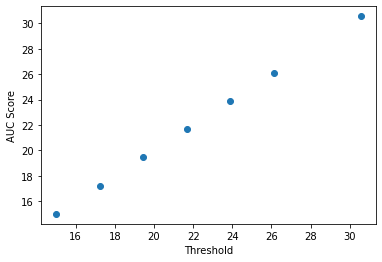

In [8]:
from sklearn.metrics import roc_auc_score


def compute_auc_score(image_paths_class1, image_paths_class2, direction, threshold,class_names):
    y_true = np.concatenate((np.ones(len(image_paths_class1)), np.zeros(len(image_paths_class2))))
    y_scores = []

    # Class 1 images
    for image_path in image_paths_class1:
        score, _ = compute_discriminant_score(image_path, direction, threshold,class_names)
        y_scores.append(score)

    # Class 2 images
    for image_path in image_paths_class2:
        score, _ = compute_discriminant_score(image_path, direction, threshold,class_names)
        y_scores.append(score)
        
    result = []
    for score in y_scores:
        if score < threshold:
            result.append(1)
        else:
            result.append(0)

    y_scores = np.array(result)
    auc_score = roc_auc_score(y_true, y_scores)
    return auc_score

ls_threshold=[]
ls_auc_score=[]
def optimize_threshold(image_paths_class1, image_paths_class2, direction, threshold_range, class_names):
    best_threshold = None
    best_auc_score = -1
    
    for threshold in threshold_range:
        auc_score = compute_auc_score(image_paths_class1, image_paths_class2, direction, threshold, class_names)
        if auc_score > best_auc_score:
            best_auc_score = auc_score
            best_threshold = threshold
            print(f"Threshold: {best_threshold}")
            print(f"AUC Score: {best_auc_score}")
            ls_threshold.append(best_threshold)
            ls_auc_score.append(best_threshold)
    return best_threshold, best_auc_score


test_dir = 'data_TAD/test'
class_names = ['Healthy', 'Black_Rot']
threshold_range = np.linspace(15, 35, num=10)  # specify the range of threshold values

test_image_paths_class1 = []
test_image_paths_class2 = []

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(test_dir, class_name)
    images = [img for img in os.listdir(class_dir) if img.endswith(('.jpg', '.JPG', '.png', '.jpeg'))]
    class_indices = [os.path.join(class_dir, img) for img in images]
    if i == 0:
        test_image_paths_class1 = class_indices
    else:
        test_image_paths_class2 = class_indices

best_threshold, best_auc_score = optimize_threshold(test_image_paths_class1, test_image_paths_class2, direction, threshold_range, class_names)
print(f"Best Threshold: {best_threshold}")
print(f"Best AUC Score: {best_auc_score}")


plt.scatter(ls_threshold,ls_auc_score)
plt.xlabel("Threshold")
plt.ylabel("AUC Score")
plt.show()

### We get the best threshold score as 30.5 having AUC score of 0.95

In [9]:
threshold = best_threshold

In [10]:
#on all black_rot images

# Path to the directory containing the images
directory_path = 'data_TAD/train/Black_Rot'
score_blackrot=[]
# List all the image file names in the directory
image_files = [file for file in os.listdir(directory_path) if file.endswith(('.jpg', '.JPG', '.png'))]

# Classify each image and print the results
for image_file in image_files:
    image_path = os.path.join(directory_path, image_file)
    score, predicted_class = compute_discriminant_score(image_path, direction, threshold, class_names)
    score_blackrot.append(score)


In [11]:
#on all healthy images

# Path to the directory containing the images
directory_path = 'data_TAD/train/Healthy'
score_healthy=[]
# List all the image file names in the directory
image_files = [file for file in os.listdir(directory_path) if file.endswith(('.jpg', '.JPG', '.png'))]

# Classify each image and print the results
for image_file in image_files:
    image_path = os.path.join(directory_path, image_file)
    score, predicted_class = compute_discriminant_score(image_path, direction, threshold, class_names)
    score_healthy.append(score)

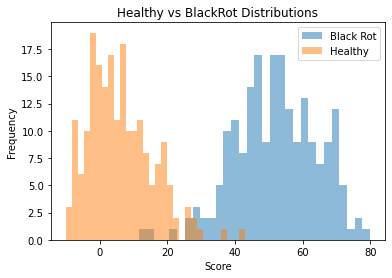

In [12]:
# Plotting
plt.hist(score_blackrot, bins=30, alpha=0.5, label='Black Rot')
plt.hist(score_healthy, bins=30, alpha=0.5, label='Healthy')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Healthy vs BlackRot Distributions')
plt.legend()

# Display the plot
plt.show()

In [13]:
# Classify a new instance
new_instance_path = 'data_TAD/test/Black_Rot/image (544).JPG'  
score, predicted_class = compute_discriminant_score(new_instance_path, direction, threshold,class_names)

print(f'Score: {score}')
print(f'Predicted Class: {predicted_class}')



Score: 55.461856842041016
Predicted Class: Black_Rot


In [14]:
# Classify a new instance
new_instance_path = 'data_TAD/test/Healthy/image (1317).JPG'  # Replace with the path to your test image
score, predicted_class = compute_discriminant_score(new_instance_path, direction, threshold,class_names)
print(f'Score: {score}')
print(f'Predicted Class: {predicted_class}')


Score: -0.16767853498458862
Predicted Class: Healthy


# 4.1

In [15]:
import matplotlib.pyplot as plt

# Preprocess the input image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load and preprocess the image
image_path = 'data_TAD/train/Black_Rot/image (50).JPG'
image = Image.open(image_path).convert('RGB')
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)
print(input_batch.shape)

torch.Size([1, 3, 224, 224])


In [16]:
model_vgg16.eval()

# Enabling calculating the gradient on our input
input_batch.requires_grad = True

# getting the result
output = model_vgg16(input_batch)

# print("output", output)
print("output.shape", output.shape)


# Obtaining the predicted class index
_, predicted_idx = torch.max(output, 1)
# print("predicted_idx",predicted_idx)
print("predicted_idx.shape",predicted_idx.shape)


output.shape torch.Size([1, 1000])
predicted_idx.shape torch.Size([1])


In [17]:
#Process to calculate gradient

# Calculate the gradients
output[0, predicted_idx].backward()

# Get the gradients of the input tensor
gradients = input_batch.grad[0]

# print("input_batch",input_batch)
print("input_batch shape",input_batch.shape)
# print("gradients",gradients)
print("gradients shape",gradients.shape)

input_batch shape torch.Size([1, 3, 224, 224])
gradients shape torch.Size([3, 224, 224])


One image has been resized to 224 * 224 pixels, each in R,G,B., having the shape [1,(3, 224, 224)]

We have importance score (which is the Gradient) along each of the three dimensions (R,G,B) stored in the variable gradients. gradients shape is ([3, 224, 224])

Now, we are accumulating the importance scores along each of our three directions (r,g,b) so we can have a final importance score of size 224 * 224

In [18]:
importance_scores = torch.norm(gradients, p=2, dim=0,keepdim=False)

importance_scores.shape

torch.Size([224, 224])

In [19]:
importance_scores

tensor([[0.0043, 0.0160, 0.0107,  ..., 0.0364, 0.0360, 0.0228],
        [0.0121, 0.0187, 0.0060,  ..., 0.1484, 0.0459, 0.0446],
        [0.0045, 0.0308, 0.0180,  ..., 0.2361, 0.1559, 0.0382],
        ...,
        [0.0176, 0.0176, 0.0732,  ..., 0.1261, 0.1623, 0.0110],
        [0.0134, 0.0401, 0.0347,  ..., 0.0898, 0.1140, 0.0205],
        [0.0096, 0.0408, 0.0085,  ..., 0.0414, 0.0348, 0.0149]])


`heatmap = importance_scores.detach().numpy()`
   - `importance_scores` is a PyTorch tensor containing the importance scores.
   - `.detach()` is a method that creates a new tensor that shares the same data as `importance_scores` but does not require gradient computation.
   - `.numpy()` converts the detached tensor to a NumPy array.
   - So, `heatmap` becomes a NumPy array containing the importance scores.

`heatmap = np.uint8(255 * heatmap)`
   - `np.uint8` is a NumPy data type that represents unsigned 8-bit integers (values from 0 to 255).
   - `255 * heatmap` scales the values of the `heatmap` array to the range of 0 to 255.
   - The resulting scaled values are then cast to the `np.uint8` data type.
   - As a result, `heatmap` now contains the importance scores represented as an 8-bit integer array in the range of 0 to 255.

In summary, these two lines of code convert the importance scores from a PyTorch tensor to a NumPy array and scale the values to the range of 0 to 255 to prepare them for visualization as a heatmap image.

In [20]:
# Convert the importance scores to a heatmap image
heatmap = importance_scores.detach().numpy()
heatmap = np.uint8(255 * heatmap)

# Resize the heatmap to match the size of the original image
heatmap_resized = np.array(Image.fromarray(heatmap).resize((image.width, image.height)))

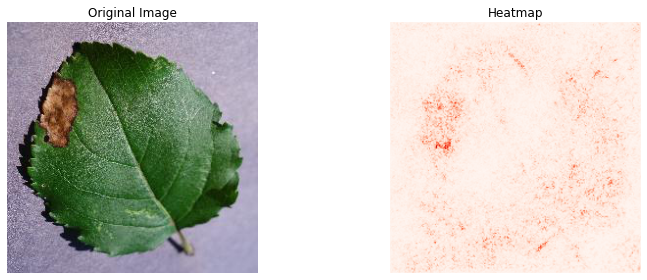

In [21]:
# Apply colormap to the heatmap
colormap = plt.cm.get_cmap('Reds')
heatmap_colored = colormap(heatmap_resized)
heatmap_colored = np.delete(heatmap_colored, 3, 2)  # Remove the alpha channel


# Plot the original image, heatmap, and overlay
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(heatmap_resized, cmap='Reds')
axes[1].set_title('Heatmap')
axes[1].axis('off')

plt.tight_layout()
plt.show()


# 4.2

In [22]:
model_vgg16_features = models.vgg16(pretrained=True).features
model_vgg16_features.add_module('flatten', torch.nn.Flatten())

/Users/namrata/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/namrata/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
model_vgg16_features.eval()


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [24]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load and preprocess the image
image_path = 'data_TAD/test/Black_Rot/image (542).JPG'
image = Image.open(image_path).convert('RGB')
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)
print(input_batch.shape)

torch.Size([1, 3, 224, 224])


In [25]:
model_vgg16_features(input_batch)

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ReshapeAliasBackward0>)

In [26]:
import torch
import torch.nn as nn
import torchvision.models as models
from copy import deepcopy
class BiasedLayer(nn.Module):
    def __init__(self, original_layer,gamma:float):
        super(BiasedLayer, self).__init__()

        # Clone the original layer
        self.layer = original_layer
        self.gamma = gamma
        # self.biased_layer = self.clone_layer_with_bias(original_layer)
        self.biased_layer = deepcopy(self.layer)
        self.biased_layer.bias = nn.Parameter(self.layer.bias+ self.gamma * torch.relu(self.layer.bias))
        self.biased_layer.weight = nn.Parameter(self.layer.weight + self.gamma * torch.relu(self.layer.weight))


    def forward(self, x):

        original_output = self.layer(x)
        biased_output = self.biased_layer(x)
        biased_output_detached = biased_output.detach()
        original_output_detached = original_output.detach()

        scaling_factor = original_output_detached / biased_output_detached

        output = biased_output * scaling_factor

        return output

#
# Modify the VGG-16 model by replacing certain layers with biased versions
modified_model = model_vgg16_features
for name, module in modified_model.named_children():
    if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
        modified_model._modules[name] = BiasedLayer(module,gamma=0.25)



In [27]:
modified_model.eval()

Sequential(
  (0): BiasedLayer(
    (layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (biased_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (1): ReLU(inplace=True)
  (2): BiasedLayer(
    (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (biased_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): BiasedLayer(
    (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (biased_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (6): ReLU(inplace=True)
  (7): BiasedLayer(
    (layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (biased_layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, 

In [28]:
modified_model(input_batch)

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ReshapeAliasBackward0>)

In [29]:
# Load and preprocess the image
image_path = 'data_TAD/train/Black_Rot/image (50).JPG'
image = Image.open(image_path).convert('RGB')
input_tensor_new = preprocess(image)
input_batch_new = input_tensor_new.unsqueeze(0)
print(input_batch_new.shape)
input_batch_new.requires_grad = True
output = modified_model(input_batch_new)
output.backward(torch.ones_like(output))
gradient = input_batch_new.grad
gradient_squeezed  = gradient.squeeze(0)

square_norm =  torch.norm(gradient_squeezed,p=2,  dim=(0))

importance_scores_modified = square_norm/torch.max(square_norm)

heatmap_modified = importance_scores_modified.detach().numpy()
heatmap_modified = np.uint8(255 * heatmap_modified)

# Resize the heatmap to match the size of the original image
heatmap_modified_resized = np.array(Image.fromarray(heatmap_modified).resize((image.width, image.height)))


torch.Size([1, 3, 224, 224])


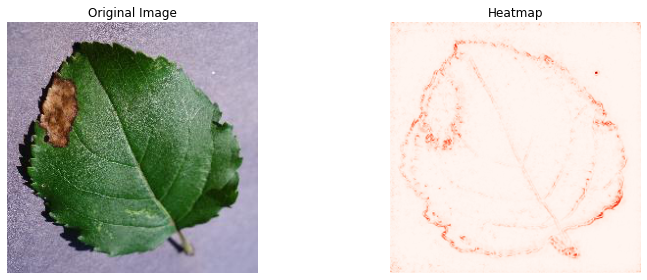

In [30]:
# Apply colormap to the heatmap
colormap = plt.cm.get_cmap('Reds')
heatmap_colored_modified = colormap(heatmap_modified_resized)
heatmap_colored_modified = np.delete(heatmap_colored_modified, 3, 2)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(heatmap_modified_resized, cmap='Reds')
axes[1].set_title('Heatmap')
axes[1].axis('off')

plt.tight_layout()
plt.show()
